## LCNN model implementation with CQT

In [1]:
import datetime

import tensorflow as tf
import numpy as np
import os

from utils.DataLoader import data_loader
from utils.Generator0 import DataGenerator, feature_extract_cqt, evalEER,  evalScore, evalEER_f, evalEER_f2, gen_fname

2022-11-04 09:24:37.189014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [176]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Nov 23 09:38:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   35C    P0    39W / 300W |      2MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

## Dataset gathering and preparation

In [6]:
add2022 = '/home/ubuntu/data/ADD/'
asv2019 = '/home/ubuntu/data/asv2019'

pathset = { 'add2022' : add2022 , 'asv2019':asv2019}

dl = data_loader(pathset)


In [7]:
 ## 1:ADD, 2:LA
dl.get_data(data_pick = '1', tde_pick = 't', to = 't')
dl.get_data(data_pick = '1', tde_pick = 'd', to = 'd')
dl.get_data(data_pick = '1', tde_pick = 'e', to = 'e')

In [8]:
len(dl.train)

27084

In [9]:
len(dl.dev)

28324

In [10]:
len(dl.eval)

1000

### Hyper parameters

In [11]:
sr = 16000
sec = 9.0
batch_size = 16
feature = "cqt"
filter_scale = 1
n_bins = 100
fmin = 5


epoch = 50
dropout_rate = 0.5
human_weight = 5.0

tmp_string = "tmp"

### 1. FFM, random filter

In [12]:
params = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': True,
          'beta_param': 0.7,
          'data_dir': add2022,
#          'lowpass': [11,12,13,14,15,16,17,18],
          #'highpass': [78,79,80,81,82,83,84,85],
          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': False,
          'data_dir': add2022,
          #'device': device
}

In [13]:
training_generator = DataGenerator(dl.train, dl.labels, **params)
validation_generator = DataGenerator(dl.dev, dl.labels, **params_no_shuffle)
evaluation_generator = DataGenerator(dl.eval, dl.labels, **params_no_shuffle)

cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)


In [12]:
training_generator[0][0].shape

(16, 100, 282, 1)

In [22]:
training_generator[0][0][3].shape

(100, 282, 1)

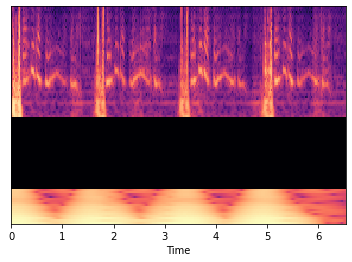

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[0][0][3][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)

### No augmentation

In [28]:
params = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': True,
          'beta_param': 0.7,
          'data_dir': add2022,
#          'specmix': [[2,10], [2,15]],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': False,
          'data_dir': add2022,
          #'device': device
}

In [15]:
training_generator = DataGenerator(dl.train, dl.labels, **params)
validation_generator = DataGenerator(dl.dev, dl.labels, **params_no_shuffle)
evaluation_generator = DataGenerator(dl.eval, dl.labels, **params_no_shuffle)

cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)


우리 피쳐

In [18]:
training_generator[0][0].shape

(16, 100, 282, 1)

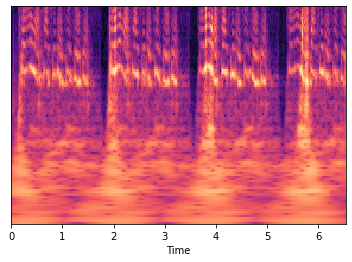

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[0][0][0][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)

파라메터들 확인

In [40]:
batch_size, n_freq_bin, _ , _  = training_generator[0][0].shape

print( "batch_size:{}, n_freq_bin:{}".format(batch_size, n_freq_bin))

batch_size:16, n_freq_bin:100


In [41]:
n_band, min_bw, f_type, db_range = [[3,6], 6, "step", [-6,6]]   #self.filteraug 

print( "Parameters: \nn_band:{}, min_bw:{}, f_type:{}, db_range:{}".format(n_band, min_bw, f_type, db_range))

Parameters: 
n_band:[3, 6], min_bw:6, f_type:step, db_range:[-6, 6]


In [50]:
#n_band, min_bw, f_type, db_range = [[3,6], 6, "step", [-6,6]]   #self.filteraug 
n_freq_band = np.random.randint(low = n_band[0], high = n_band[1])    

print("n_freq_band:{} is random sample from n_band:{} ".format(n_freq_band, n_band))                                                                  

n_freq_band:3 is random sample from n_band:[3, 6] 


In [172]:
n_band2 = [[2,5],[3,6],[5,8]] 
min_bw2 = [2,4,6,8,10]
f_type2 = "step" #np.random.choice(["step", "linear"])
db_range2 = [[-10,10],[-6,6],[-1,1]] # [-6,6]
[n_band2[np.random.choice([0,1,2])],np.random.choice(min_bw2), f_type2,db_range2[np.random.choice([0,1,2])] ]


[[2, 5], 4, 'step', [-1, 1]]

In [173]:
[round(i,2) for i in np.arange(0.1,1,0.1)]

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [175]:
n_band2 = [[2,5],[3,6],[5,8]] 
for band in n_band2:
    for i in range(3):
        min_bw2 = [2,4,6,8,10]
        f_type2 = "step" #np.random.choice(["step", "linear"])
        db_range2 = [[-10,10],[-6,6],[-1,1]] # [-6,6]
        filteraug2 = [band,np.random.choice(min_bw2), f_type2,db_range2[np.random.choice([0,1,2])]]
        print(filteraug2)

[[2, 5], 6, 'step', [-10, 10]]
[[2, 5], 6, 'step', [-10, 10]]
[[2, 5], 2, 'step', [-6, 6]]
[[3, 6], 6, 'step', [-6, 6]]
[[3, 6], 10, 'step', [-10, 10]]
[[3, 6], 4, 'step', [-6, 6]]
[[5, 8], 4, 'step', [-6, 6]]
[[5, 8], 10, 'step', [-1, 1]]
[[5, 8], 8, 'step', [-1, 1]]


In [154]:
f_type2 = np.random.choice(["step", "linear"])
np.random.choice([f_type2])

'step'

In [155]:
n_freq_bin - n_freq_band * min_bw + 1 < 0

False

In [48]:
min_bw = 30
while n_freq_bin - n_freq_band * min_bw + 1 <0:
    min_bw -=1
    print(min_bw)

29
28
27
26
25


Calculating band_boundary frequencies

In [52]:
n_freq_band - 1

2

In [61]:
band_bndry_freqs = np.sort(np.random.randint(low = 0, high = n_freq_bin - n_freq_band * min_bw + 1,
                                         size = n_freq_band - 1)) + np.arange(1,n_freq_band)*min_bw

print(band_bndry_freqs)


[42 74]


In [72]:
band_bndry_freqs = np.sort(list(set(band_bndry_freqs) | {0,n_freq_bin}))

print(band_bndry_freqs)


[  0  42  74 100]


## If f_type = "step"

In [75]:
print(batch_size)
print(n_freq_band)

16
3


16개 배치별로 n 개의 weight 계산 (나중에 곱해줌)

In [77]:
(db_range[1] - db_range[0]) 

12

In [82]:
np.random.seed(1)
np.random.uniform(size = (batch_size, n_freq_band))

array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04],
       [3.02332573e-01, 1.46755891e-01, 9.23385948e-02],
       [1.86260211e-01, 3.45560727e-01, 3.96767474e-01],
       [5.38816734e-01, 4.19194514e-01, 6.85219500e-01],
       [2.04452250e-01, 8.78117436e-01, 2.73875932e-02],
       [6.70467510e-01, 4.17304802e-01, 5.58689828e-01],
       [1.40386939e-01, 1.98101489e-01, 8.00744569e-01],
       [9.68261576e-01, 3.13424178e-01, 6.92322616e-01],
       [8.76389152e-01, 8.94606664e-01, 8.50442114e-02],
       [3.90547832e-02, 1.69830420e-01, 8.78142503e-01],
       [9.83468338e-02, 4.21107625e-01, 9.57889530e-01],
       [5.33165285e-01, 6.91877114e-01, 3.15515631e-01],
       [6.86500928e-01, 8.34625672e-01, 1.82882773e-02],
       [7.50144315e-01, 9.88861089e-01, 7.48165654e-01],
       [2.80443992e-01, 7.89279328e-01, 1.03226007e-01],
       [4.47893526e-01, 9.08595503e-01, 2.93614148e-01]])

In [86]:
np.random.seed(1)
np.random.uniform(size = (batch_size, n_freq_band))  * (db_range[1] - db_range[0]) + db_range[0]

array([[-0.99573594,  2.64389392, -5.9986275 ],
       [-2.37200913, -4.23892931, -4.89193686],
       [-3.76487746, -1.85327128, -1.23879031],
       [ 0.46580081, -0.96966583,  2.222634  ],
       [-3.546573  ,  4.53740924, -5.67134888],
       [ 2.04561012, -0.99234237,  0.70427794],
       [-4.31535674, -3.62278213,  3.60893482],
       [ 5.61913891, -2.23890986,  2.30787139],
       [ 4.51666983,  4.73527996, -4.97946946],
       [-5.5313426 , -3.96203497,  4.53771004],
       [-4.81983799, -0.9467085 ,  5.49467436],
       [ 0.39798342,  2.30252537, -2.21381243],
       [ 2.23801113,  4.01550806, -5.78054067],
       [ 3.00173178,  5.86633307,  2.97798785],
       [-2.6346721 ,  3.47135194, -4.76128792],
       [-0.62527769,  4.90314604, -2.47663022]])

In [85]:
db_range[0]

-6

In [83]:
np.random.seed(1)
np.random.uniform(size = (batch_size, n_freq_band))  * (db_range[1] - db_range[0]) + db_range[0]

array([[-0.99573594,  2.64389392, -5.9986275 ],
       [-2.37200913, -4.23892931, -4.89193686],
       [-3.76487746, -1.85327128, -1.23879031],
       [ 0.46580081, -0.96966583,  2.222634  ],
       [-3.546573  ,  4.53740924, -5.67134888],
       [ 2.04561012, -0.99234237,  0.70427794],
       [-4.31535674, -3.62278213,  3.60893482],
       [ 5.61913891, -2.23890986,  2.30787139],
       [ 4.51666983,  4.73527996, -4.97946946],
       [-5.5313426 , -3.96203497,  4.53771004],
       [-4.81983799, -0.9467085 ,  5.49467436],
       [ 0.39798342,  2.30252537, -2.21381243],
       [ 2.23801113,  4.01550806, -5.78054067],
       [ 3.00173178,  5.86633307,  2.97798785],
       [-2.6346721 ,  3.47135194, -4.76128792],
       [-0.62527769,  4.90314604, -2.47663022]])

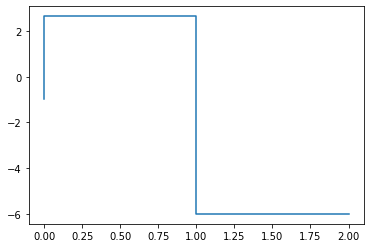

In [88]:
plt.step([0,1,2],[-0.99573594, 2.64389392, -5.9986275])

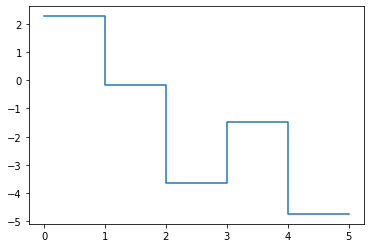

In [87]:
plt.step([0,1,2,3,4,5], [ 2.26352632, 2.26352632, -0.16635634, -3.64649415, -1.4921597 , -4.7341842 ])

In [99]:
band_factors = np.random.uniform(size = (batch_size, n_freq_band))  * (db_range[1] - db_range[0]) + db_range[0]

# 10의 제곱승을 하는 이유?
band_factors = 10 ** (band_factors / 20)

band_factors

array([[0.74587354, 0.59981475, 0.51477823],
       [1.28026927, 0.67139309, 0.72331587],
       [0.9884254 , 0.5395324 , 1.10782347],
       [0.6138145 , 1.13131442, 1.31781673],
       [0.5772988 , 0.88804218, 1.30809744],
       [0.88819344, 0.53699727, 1.05084302],
       [1.25394009, 1.02078309, 1.84823357],
       [1.12702364, 1.74598758, 0.60601702],
       [0.60752731, 1.52909607, 0.86817265],
       [0.6298143 , 1.80511614, 0.81032552],
       [1.41412325, 1.36646588, 1.69817974],
       [1.18632402, 1.4143779 , 0.81159433],
       [0.72770731, 1.72795223, 0.90542965],
       [1.90065822, 1.25332845, 1.18308904],
       [0.58728321, 1.86077368, 0.93314102],
       [1.11438118, 0.88080969, 0.69537038]])

피쳐 차원으로 곱해줄 값들 확장

In [100]:
freq_filt = np.zeros((batch_size, n_freq_bin, 282, 1))
for b in range(batch_size) :
    for i in range(n_freq_band):
        freq_filt[b, band_bndry_freqs[i]:band_bndry_freqs[i + 1], :, :] = band_factors[b, i]


차원 맞는지 확인

In [101]:
freq_filt

array([[[[0.74587354],
         [0.74587354],
         [0.74587354],
         ...,
         [0.74587354],
         [0.74587354],
         [0.74587354]],

        [[0.74587354],
         [0.74587354],
         [0.74587354],
         ...,
         [0.74587354],
         [0.74587354],
         [0.74587354]],

        [[0.74587354],
         [0.74587354],
         [0.74587354],
         ...,
         [0.74587354],
         [0.74587354],
         [0.74587354]],

        ...,

        [[0.51477823],
         [0.51477823],
         [0.51477823],
         ...,
         [0.51477823],
         [0.51477823],
         [0.51477823]],

        [[0.51477823],
         [0.51477823],
         [0.51477823],
         ...,
         [0.51477823],
         [0.51477823],
         [0.51477823]],

        [[0.51477823],
         [0.51477823],
         [0.51477823],
         ...,
         [0.51477823],
         [0.51477823],
         [0.51477823]]],


       [[[1.28026927],
         [1.28026927],
         [1.28

In [103]:
training_generator[0][0].shape

(16, 100, 282, 1)

In [104]:
freq_filt.shape

(16, 100, 282, 1)

In [110]:
ori = training_generator[0][0]

In [111]:
res = ori * freq_filt

In [112]:
res[0].shape

(100, 282, 1)

계산 결과 확인
high: darcker, low: lighter 

0:th batch sample / 16
[  0  42  74 100]
[0.74587354 0.59981475 0.51477823]


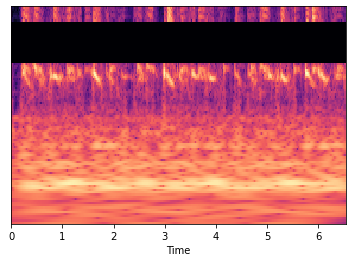

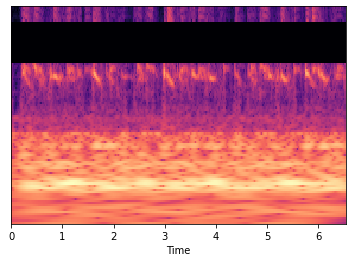

In [113]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


숫자 표시

0:th batch sample / 16
[  0  42  74 100]
[0.74587354 0.59981475 0.51477823]


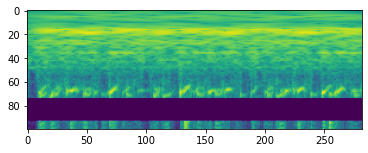

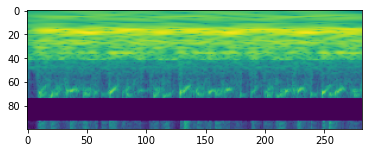

In [114]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
plt.imshow(ori[i][:,:,0])
fig, ax = plt.subplots()
plt.imshow(res[i][:,:,0])


1:th batch sample / 16
[  0  42  74 100]
[1.28026927 0.67139309 0.72331587]


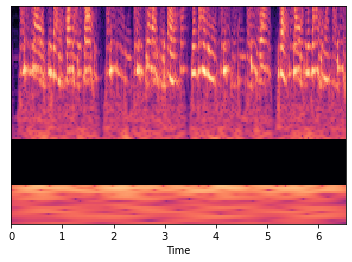

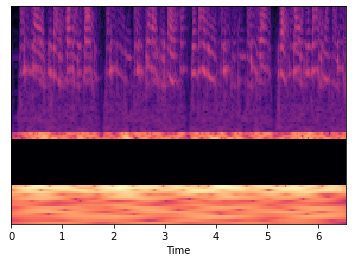

In [119]:
i = 1
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


2:th batch sample / 16
[  0  42  74 100]
[0.9884254  0.5395324  1.10782347]


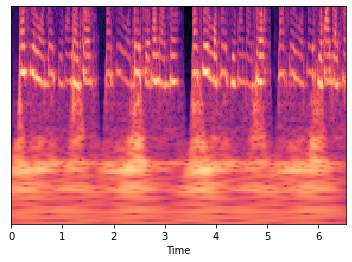

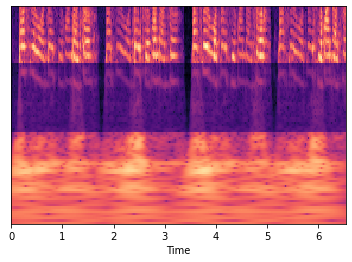

In [120]:
i = 2
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


3:th batch sample / 16
[  0  18  36  59  85 100]
[1.50188439 1.16591284 1.7223678  0.51904225 1.3057966 ]


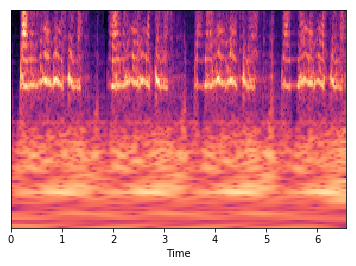

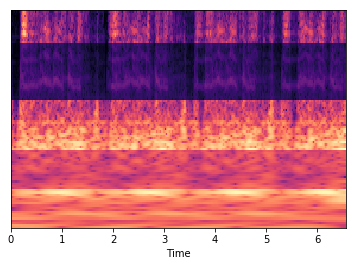

In [103]:
i = 3
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


4:th batch sample / 16
[  0  42  74 100]
[0.5772988  0.88804218 1.30809744]


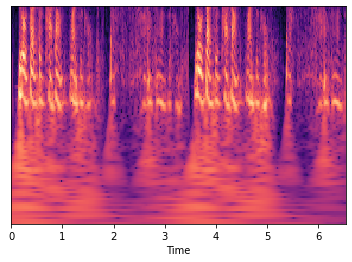

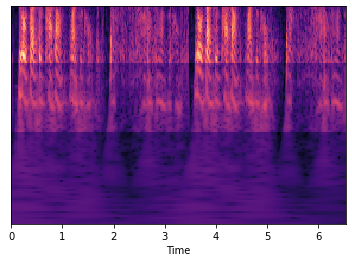

In [124]:
i = 4
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


5:th batch sample / 16
[  0  42  74 100]
[0.88819344 0.53699727 1.05084302]


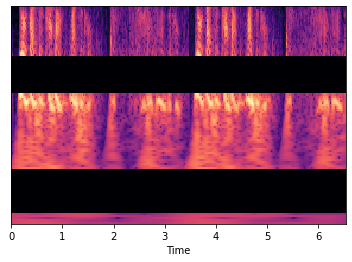

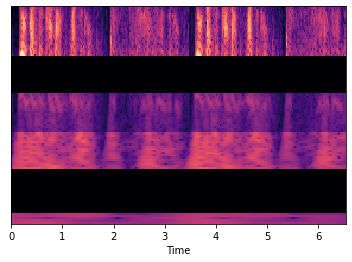

In [125]:
i = 5
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


## If f_type = "linear"

In [126]:
batch_size

16

In [127]:
band_factors = np.random.uniform(size = (batch_size, n_freq_band+ 1))  * (db_range[1] - db_range[0]) + db_range[0]

band_factors

array([[-3.59674306,  1.50133912, -2.14257806, -5.43218121],
       [ 2.68037704,  3.11102402, -1.12434833,  2.45202032],
       [ 1.02431057,  5.63477412, -2.35345886, -2.23493544],
       [-3.2824606 ,  2.06801474,  3.34706692,  0.15194039],
       [ 1.38317923, -5.45206592, -0.64680592,  5.61615185],
       [-1.68527628,  0.64838581, -1.06374702,  5.59255874],
       [-3.56330583,  5.91391884,  1.91039957,  3.7089269 ],
       [-0.50218952,  4.64769656,  0.407212  ,  0.92735336],
       [ 5.00997949, -2.23024174,  2.7136613 ,  3.66283006],
       [-0.23924485, -0.14910756,  4.09692071,  0.66633042],
       [-2.76142448, -0.15908743, -2.68984927, -3.29531432],
       [ 1.76104695,  5.05360297, -3.59430295,  4.55823724],
       [-0.4103076 ,  2.69976146, -2.36554417, -0.13191247],
       [-3.55590806, -4.9366049 , -4.01172429,  0.03595839],
       [ 3.4509721 ,  4.8432224 , -3.36571089,  2.85757164],
       [-2.90636533,  0.77050493, -4.4108444 , -1.53494785]])

In [135]:
range(n_freq_band+ 1)

range(0, 4)

In [132]:
n_freq_band

3

In [129]:
band_factors[0]

array([-3.59674306,  1.50133912, -2.14257806, -5.43218121])

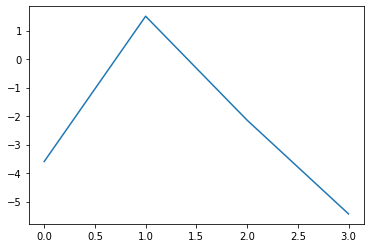

In [133]:
plt.plot(range(n_freq_band+ 1), band_factors[0])

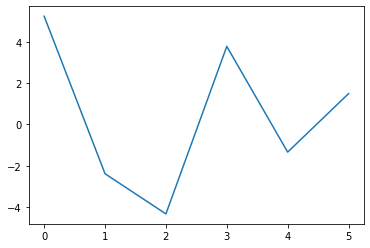

In [65]:
plt.plot([0,1,2,3,4,5], [ 5.23011213e+00, -2.38848414e+00, -4.33200127e+00, 3.77122333e+00, -1.34161560e+00,  1.48481023e+00])

In [137]:
i =1
band_bndry_freqs[i+1] - band_bndry_freqs[i]

32

In [138]:
band_factors

array([[-3.59674306,  1.50133912, -2.14257806, -5.43218121],
       [ 2.68037704,  3.11102402, -1.12434833,  2.45202032],
       [ 1.02431057,  5.63477412, -2.35345886, -2.23493544],
       [-3.2824606 ,  2.06801474,  3.34706692,  0.15194039],
       [ 1.38317923, -5.45206592, -0.64680592,  5.61615185],
       [-1.68527628,  0.64838581, -1.06374702,  5.59255874],
       [-3.56330583,  5.91391884,  1.91039957,  3.7089269 ],
       [-0.50218952,  4.64769656,  0.407212  ,  0.92735336],
       [ 5.00997949, -2.23024174,  2.7136613 ,  3.66283006],
       [-0.23924485, -0.14910756,  4.09692071,  0.66633042],
       [-2.76142448, -0.15908743, -2.68984927, -3.29531432],
       [ 1.76104695,  5.05360297, -3.59430295,  4.55823724],
       [-0.4103076 ,  2.69976146, -2.36554417, -0.13191247],
       [-3.55590806, -4.9366049 , -4.01172429,  0.03595839],
       [ 3.4509721 ,  4.8432224 , -3.36571089,  2.85757164],
       [-2.90636533,  0.77050493, -4.4108444 , -1.53494785]])

In [61]:
freq_filt = np.zeros((batch_size, n_freq_bin, 282, 1))
for b in range(batch_size) :
    for i in range(n_freq_band):
        freq_filt[b, band_bndry_freqs[i]:band_bndry_freqs[i + 1], :, :] = np.linspace(band_factors[b, i], band_factors[b, i+1],
                                       band_bndry_freqs[i+1] - band_bndry_freqs[i])[:,np.newaxis,np.newaxis]

In [141]:
b = 0
i = 0
np.linspace(band_factors[b, i], band_factors[b, i+1],
                                       band_bndry_freqs[i+1] - band_bndry_freqs[i])

array([-3.59674306, -3.47239959, -3.34805613, -3.22371266, -3.09936919,
       -2.97502572, -2.85068225, -2.72633879, -2.60199532, -2.47765185,
       -2.35330838, -2.22896491, -2.10462145, -1.98027798, -1.85593451,
       -1.73159104, -1.60724758, -1.48290411, -1.35856064, -1.23421717,
       -1.1098737 , -0.98553024, -0.86118677, -0.7368433 , -0.61249983,
       -0.48815636, -0.3638129 , -0.23946943, -0.11512596,  0.00921751,
        0.13356098,  0.25790444,  0.38224791,  0.50659138,  0.63093485,
        0.75527832,  0.87962178,  1.00396525,  1.12830872,  1.25265219,
        1.37699566,  1.50133912])

In [62]:
freq_filt = 10 ** (freq_filt / 20)

In [63]:
ori = training_generator[0][0]

In [64]:
res = ori * freq_filt

In [112]:
res[0].shape

(100, 282, 1)

high: darcker, low: lighter 

0:th batch sample / 16
[  0  18  36  59  85 100]
[0.50142194 0.50840306 1.97902194 1.12469969 1.13349828 0.53991792]


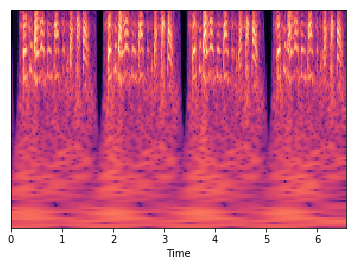

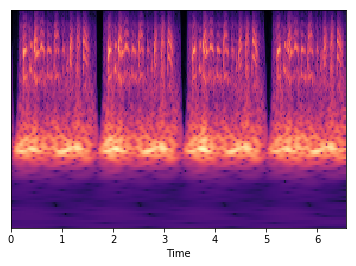

In [113]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


1:th batch sample / 16
[  0  18  36  59  85 100]
[1.86078142 0.97782083 0.57406267 0.81924282 0.66814645 1.56760573]


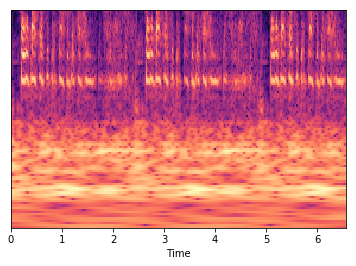

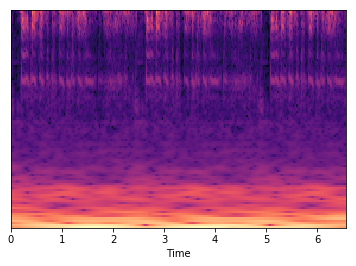

In [114]:
i = 1
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


2:th batch sample / 16
[  0  18  36  59  85 100]
[1.05109108 0.75662    1.80938657 1.094062   1.08046102 1.08376444]


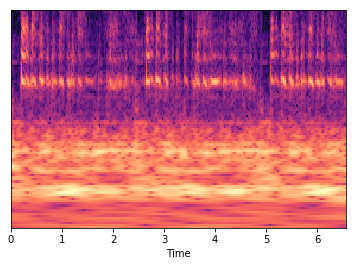

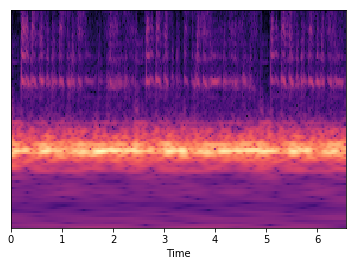

In [115]:
i = 2
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


3:th batch sample / 16
[  0  18  36  59  85 100]
[0.55072985 1.00997124 0.57685861 1.18440355 1.07627242 0.97727626]


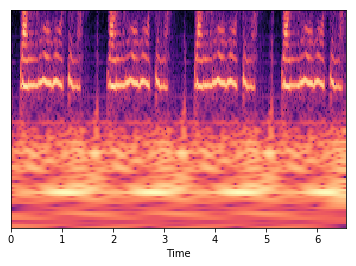

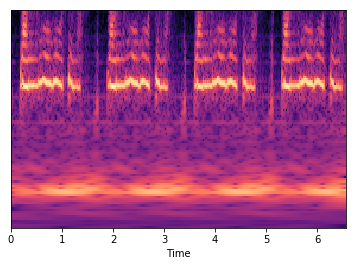

In [116]:
i = 3
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


4:th batch sample / 16
[  0  18  36  59  85 100]
[0.75791229 0.8965659  0.68476283 0.53782038 1.84972913 0.57750429]


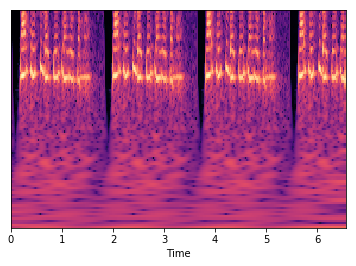

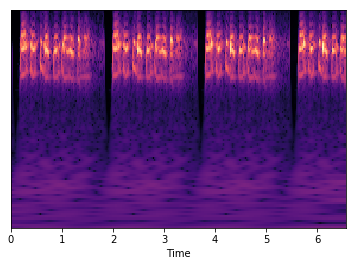

In [117]:
i = 4
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


5:th batch sample / 16
[  0   6  27  74 100]
[0.645423   1.62883945 1.61455163 0.83609569 1.66327964]


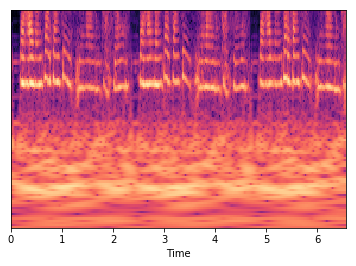

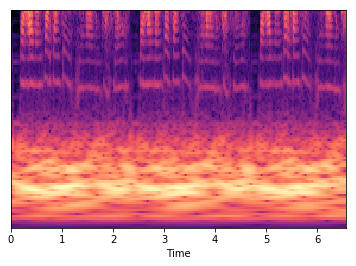

In [55]:
i = 5
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


## FFM LP, HP step, linear

파라메터들 확인

In [94]:
batch_size, n_freq_bin, _ , _  = training_generator[0][0].shape

print( "batch_size:{}, n_freq_bin:{}".format(batch_size, n_freq_bin))

batch_size:16, n_freq_bin:100


In [100]:
n_band, min_bw, f_type, db_range = [[3,6], 6, "step", [-6,0]]   #self.filteraug 

print( "Parameters: \nn_band:{}, min_bw:{}, f_type:{}, db_range:{}".format(n_band, min_bw, f_type, db_range))

Parameters: 
n_band:[3, 6], min_bw:6, f_type:step, db_range:[-6, 0]


In [101]:
#n_band, min_bw, f_type, db_range = [[3,6], 6, "step", [-6,6]]   #self.filteraug 
n_freq_band = np.random.randint(low = n_band[0], high = n_band[1])    

print("n_freq_band:{} is random sample from n_band:{} ".format(n_freq_band, n_band))                                                                  

n_freq_band:5 is random sample from n_band:[3, 6] 


In [102]:
n_freq_bin - n_freq_band * min_bw + 1 < 0

False

Calculating band_boundary frequencies

In [103]:
n_freq_band - 1

4

In [104]:
band_bndry_freqs = np.sort(np.random.randint(low = 0, high = n_freq_bin - n_freq_band * min_bw + 1,
                                         size = n_freq_band - 1)) + np.arange(1,n_freq_band)*min_bw

print(band_bndry_freqs)


[16 42 68 85]


In [105]:
band_bndry_freqs = np.sort(list(set(band_bndry_freqs) | {0,n_freq_bin}))

print(band_bndry_freqs)


[  0  16  42  68  85 100]


## If f_type = "step"

In [106]:
batch_size

16

16개 배치별로 n 개의 weight 계산 (나중에 곱해줌)

In [109]:
band_factors = np.zeros((batch_size, n_freq_band))

In [110]:
band_factors[:,[0, n_freq_band-1]] = np.random.uniform(size = (batch_size, 2))  * (db_range[1] - db_range[0]) + db_range[0]

In [111]:
#band_factors = np.random.uniform(size = (batch_size, n_freq_band))  * (db_range[1] - db_range[0]) + db_range[0]
band_factors = 10 ** (band_factors / 20)

band_factors

array([[0.74530323, 1.        , 1.        , 1.        , 0.72275543],
       [0.84601409, 1.        , 1.        , 1.        , 0.76075651],
       [0.59683265, 1.        , 1.        , 1.        , 0.5907348 ],
       [0.5707858 , 1.        , 1.        , 1.        , 0.65171329],
       [0.53924869, 1.        , 1.        , 1.        , 0.95082693],
       [0.62774091, 1.        , 1.        , 1.        , 0.69442758],
       [0.75051381, 1.        , 1.        , 1.        , 0.79997006],
       [0.89391192, 1.        , 1.        , 1.        , 0.97511904],
       [0.64717428, 1.        , 1.        , 1.        , 0.51633398],
       [0.89108343, 1.        , 1.        , 1.        , 0.8467223 ],
       [0.66640546, 1.        , 1.        , 1.        , 0.71715042],
       [0.60037468, 1.        , 1.        , 1.        , 0.60469424],
       [0.8777305 , 1.        , 1.        , 1.        , 0.54593344],
       [0.65645312, 1.        , 1.        , 1.        , 0.98249273],
       [0.71331397, 1.        , 1.

In [112]:
band_factors[1,]

array([0.84601409, 1.        , 1.        , 1.        , 0.76075651])

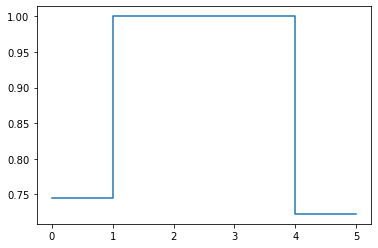

In [116]:
plt.step([0,1,2,3,4,5], [0.74530323,0.74530323, 1.        , 1.        , 1.        , 0.72275543])

피쳐 차원으로 곱해줄 값들 확장

In [117]:
freq_filt = np.zeros((batch_size, n_freq_bin, 282, 1))
for b in range(batch_size) :
    for i in range(n_freq_band):
        freq_filt[b, band_bndry_freqs[i]:band_bndry_freqs[i + 1], :, :] = band_factors[b, i]


차원 맞는지 확인

In [118]:
training_generator[0][0].shape

(16, 100, 282, 1)

In [119]:
freq_filt.shape

(16, 100, 282, 1)

In [120]:
ori = training_generator[0][0]

In [121]:
res = ori * freq_filt

In [122]:
res[0].shape

(100, 282, 1)

계산 결과 확인
high: darcker, low: lighter 

0:th batch sample / 16
[  0  16  42  68  85 100]
[0.74530323 1.         1.         1.         0.72275543]


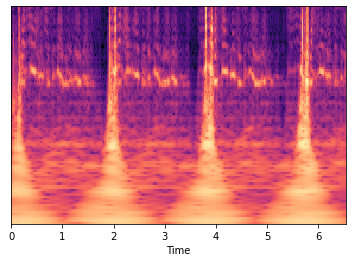

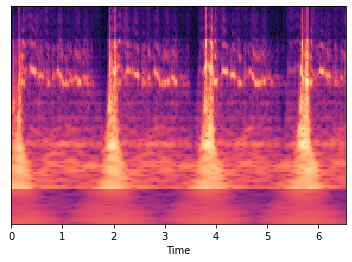

In [123]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


숫자 표시

0:th batch sample / 16
[  0  16  42  68  85 100]
[0.74530323 1.         1.         1.         0.72275543]


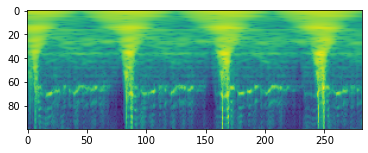

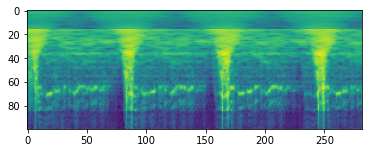

In [124]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print(band_factors[i])
fig, ax = plt.subplots()
plt.imshow(ori[i][:,:,0])
fig, ax = plt.subplots()
plt.imshow(res[i][:,:,0])


## If f_type = "linear"

In [125]:
batch_size

16

In [130]:
band_factors = np.zeros((batch_size, n_freq_band+1))

In [131]:
band_factors[:,[0, n_freq_band]] = np.random.uniform(size = (batch_size, 2))  * (db_range[1] - db_range[0]) + db_range[0]

In [132]:
#band_factors = np.random.uniform(size = (batch_size, n_freq_band+ 1))  * (db_range[1] - db_range[0]) + db_range[0]

band_factors

array([[-1.94866932,  0.        ,  0.        ,  0.        ,  0.        ,
        -3.16274805],
       [-3.07519411,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.45849055],
       [-0.9246817 ,  0.        ,  0.        ,  0.        ,  0.        ,
        -3.46556141],
       [-0.75191246,  0.        ,  0.        ,  0.        ,  0.        ,
        -4.68850523],
       [-1.38162659,  0.        ,  0.        ,  0.        ,  0.        ,
        -5.74516692],
       [-4.56235177,  0.        ,  0.        ,  0.        ,  0.        ,
        -5.9650231 ],
       [-2.88131217,  0.        ,  0.        ,  0.        ,  0.        ,
        -4.89872373],
       [-5.63771976,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.51514179],
       [-1.99634504,  0.        ,  0.        ,  0.        ,  0.        ,
        -4.80165827],
       [-3.44057148,  0.        ,  0.        ,  0.        ,  0.        ,
        -3.88054178],
       [-1.69082339,  0.        ,  0.        ,  0.

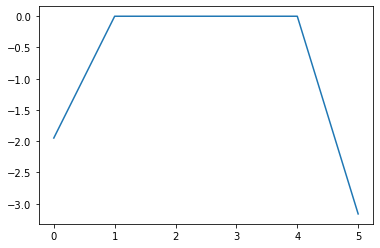

In [135]:
plt.plot(band_factors[0])

In [136]:
freq_filt = np.zeros((batch_size, n_freq_bin, 282, 1))
for b in range(batch_size) :
    for i in range(n_freq_band):
        freq_filt[b, band_bndry_freqs[i]:band_bndry_freqs[i + 1], :, :] = np.linspace(band_factors[b, i], band_factors[b, i+1],
                                       band_bndry_freqs[i+1] - band_bndry_freqs[i])[:,np.newaxis,np.newaxis]

In [137]:
freq_filt = 10 ** (freq_filt / 20)

In [138]:
ori = training_generator[0][0]

In [139]:
res = ori * freq_filt

In [140]:
res[0].shape

(100, 282, 1)

high: darcker, low: lighter 

0:th batch sample / 16
[  0  16  42  68  85 100]
[0.79903634 1.         1.         1.         1.         0.69480446]


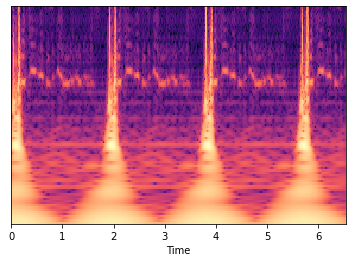

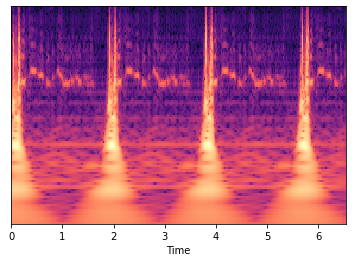

In [141]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


1:th batch sample / 16
[  0  16  42  68  85 100]
[0.70184352 1.         1.         1.         1.         0.84542575]


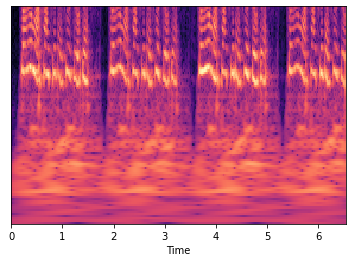

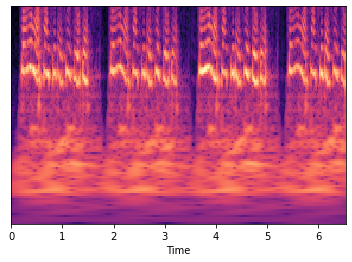

In [142]:
i = 1
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


## New idea bell augment

In [192]:
def gen_bel(x,c, p=1) :
    return p * np.exp(-(x-c)**2/2)

In [193]:
np.exp(3^2)

2.718281828459045

In [194]:
with_param = 100
center_param = 10
arr1 = np.array(range(n_freq_bin))/with_param
center = arr1[center_param]

In [195]:
gen_bel(arr1, center)

array([0.99501248, 0.99595819, 0.99680511, 0.997553  , 0.99820162,
       0.99875078, 0.99920032, 0.9995501 , 0.99980002, 0.99995   ,
       1.        , 0.99995   , 0.99980002, 0.9995501 , 0.99920032,
       0.99875078, 0.99820162, 0.997553  , 0.99680511, 0.99595819,
       0.99501248, 0.99396826, 0.99282586, 0.9915856 , 0.99024786,
       0.98881304, 0.98728157, 0.9856539 , 0.98393051, 0.98211193,
       0.98019867, 0.97819132, 0.97609047, 0.97389674, 0.97161077,
       0.96923323, 0.96676484, 0.9642063 , 0.96155838, 0.95882184,
       0.95599748, 0.95308613, 0.95008863, 0.94700586, 0.9438387 ,
       0.94058806, 0.9372549 , 0.93384015, 0.93034481, 0.92676987,
       0.92311635, 0.91938529, 0.91557774, 0.91169479, 0.90773754,
       0.90370708, 0.89960455, 0.8954311 , 0.89118789, 0.88687609,
       0.8824969 , 0.87805153, 0.87354119, 0.86896711, 0.86433055,
       0.85963276, 0.85487502, 0.85005859, 0.84518478, 0.84025488,
       0.83527021, 0.83023208, 0.82514182, 0.82000077, 0.81481

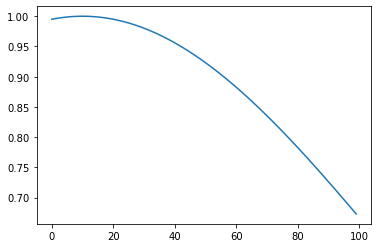

In [196]:
plt.plot(gen_bel(arr1, center))

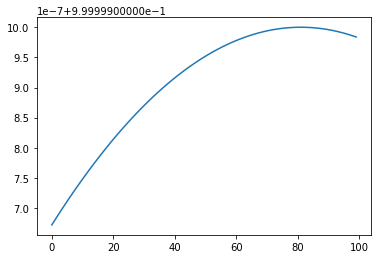

In [175]:
with_param = 100000
center_param = np.random.choice(100)
arr1 = np.array(range(n_freq_bin))/with_param
center = arr1[center_param]
plt.plot(gen_bel(arr1, center))

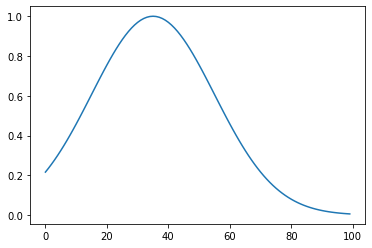

In [179]:
with_param = 20
center_param = np.random.choice(100)
arr1 = np.array(range(n_freq_bin))/with_param
center = arr1[center_param]
plt.plot(gen_bel(arr1, center))

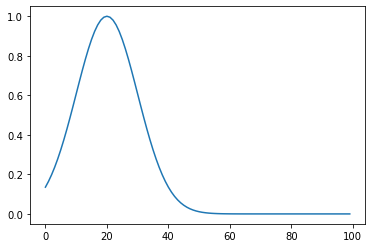

In [180]:
with_param = 10
center_param = np.random.choice(100)
arr1 = np.array(range(n_freq_bin))/with_param
center = arr1[center_param]
plt.plot(gen_bel(arr1, center))

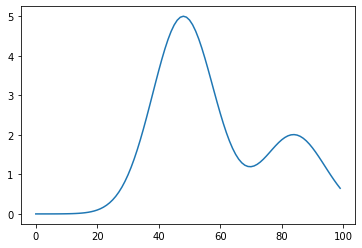

In [214]:
with_param = 10
center_param = np.random.choice(100)
center_param2 = np.random.choice(100)
arr1 = np.array(range(n_freq_bin))/with_param
center = arr1[center_param]
center2 = arr1[center_param2]
belaug = gen_bel(arr1, center, p = 2) + gen_bel(arr1, center2, p = 5)
plt.plot(belaug)

In [215]:
10 ** (belaug/20)

array([1.00000572, 1.00000919, 1.00001463, 1.00002306, 1.00003599,
       1.00005561, 1.00008505, 1.00012881, 1.00019313, 1.00028669,
       1.00042135, 1.00061312, 1.00088332, 1.00126001, 1.00177959,
       1.00248864, 1.003446  , 1.00472492, 1.00641534, 1.00862609,
       1.01148693, 1.01515031, 1.01979262, 1.02561469, 1.03284153,
       1.04172081, 1.05252013, 1.06552254, 1.08102027, 1.09930611,
       1.12066219, 1.14534572, 1.17357124, 1.20548925, 1.24116108,
       1.28053057, 1.32339368, 1.36936809, 1.41786606, 1.46807489,
       1.51895012, 1.56922708, 1.61745545, 1.66205963, 1.70142431,
       1.73400029, 1.75842095, 1.77361599, 1.77890756, 1.77407456,
       1.7593755 , 1.73552612, 1.70363553, 1.66511064, 1.62154294,
       1.57459263, 1.52588347, 1.47691786, 1.42901705, 1.38328701,
       1.34060718, 1.30163697, 1.26683466, 1.23648306, 1.21071759,
       1.18955346, 1.17290961, 1.16062848, 1.15249102, 1.14822733,
       1.1475233 , 1.15002445, 1.15533762, 1.16303203, 1.17264

In [222]:
np.array([arr1, arr1]).shape

(2, 100)

In [ ]:
[e] * n

In [ ]:
gen_bel()

In [ ]:
with_param = 10
center_param = np.random.choice(100)
center_param2 = np.random.choice(100)
arr1 = np.array(range(n_freq_bin))/with_param
center = arr1[center_param]
center2 = arr1[center_param2]
belaug = gen_bel(arr1, center, p = 2) + gen_bel(arr1, center2, p = 5)
plt.plot(belaug)

In [200]:
len(belaug)

100

In [237]:
test1 = 10**(gen_bel(np.array([arr1, arr1]), c= np.array([[2]* 100,[3]* 100])) / 10)

In [238]:
test1.shape

(2, 100)

In [240]:
test1[1,:]

array([1.00256122, 1.00344155, 1.00457903, 1.0060328 , 1.00787053,
       1.0101682 , 1.0130094 , 1.01648397, 1.02068601, 1.02571109,
       1.03165272, 1.03859791, 1.04662203, 1.05578286, 1.06611421,
       1.07761902, 1.09026259, 1.1039661 , 1.11860106, 1.13398535,
       1.14988144, 1.16599767, 1.181993  , 1.19748603, 1.2120681 ,
       1.22532047, 1.23683462, 1.24623444, 1.2531985 , 1.25748047,
       1.25892541, 1.25748047, 1.2531985 , 1.24623444, 1.23683462,
       1.22532047, 1.2120681 , 1.19748603, 1.181993  , 1.16599767,
       1.14988144, 1.13398535, 1.11860106, 1.1039661 , 1.09026259,
       1.07761902, 1.06611421, 1.05578286, 1.04662203, 1.03859791,
       1.03165272, 1.02571109, 1.02068601, 1.01648397, 1.0130094 ,
       1.0101682 , 1.00787053, 1.0060328 , 1.00457903, 1.00344155,
       1.00256122, 1.0018873 , 1.00137698, 1.00099471, 1.00071146,
       1.00050382, 1.00035324, 1.0002452 , 1.00016852, 1.00011467,
       1.00007725, 1.00005152, 1.00003402, 1.00002224, 1.00001

특정 주파수 증폭

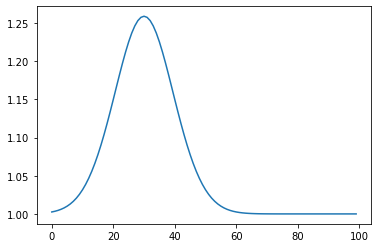

In [241]:
plt.plot(test1[1,:])

In [242]:
ori = training_generator[0][0][:2]
ori.shape

(2, 100, 282, 1)

In [243]:
res = ori * test1[:,:,np.newaxis, np.newaxis]

0:th batch sample / 16
[  0  16  42  68  85 100]
[0.79903634 1.         1.         1.         1.         0.69480446]


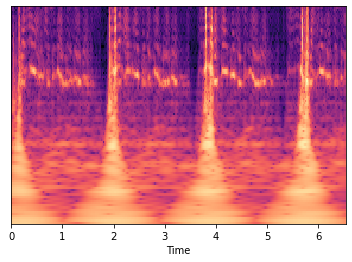

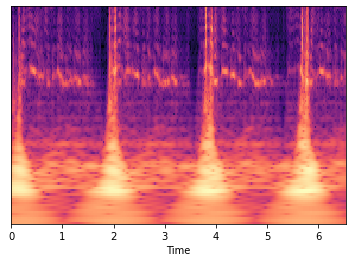

In [244]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


In [245]:
test1 = 10**(-gen_bel(np.array([arr1, arr1]), c= np.array([[2]* 100,[3]* 100])) / 10)

In [246]:
test1.shape

(2, 100)

In [247]:
test1[1,:]

array([0.99744533, 0.99657026, 0.99544184, 0.99400338, 0.99219093,
       0.98993415, 0.98715767, 0.98378334, 0.97973323, 0.9749334 ,
       0.96931843, 0.96283652, 0.95545476, 0.94716446, 0.93798581,
       0.92797175, 0.91721023, 0.90582492, 0.89397377, 0.88184561,
       0.86965487, 0.85763465, 0.8460287 , 0.83508281, 0.82503615,
       0.81611303, 0.80851553, 0.80241724, 0.79795818, 0.79524098,
       0.79432823, 0.79524098, 0.79795818, 0.80241724, 0.80851553,
       0.81611303, 0.82503615, 0.83508281, 0.8460287 , 0.85763465,
       0.86965487, 0.88184561, 0.89397377, 0.90582492, 0.91721023,
       0.92797175, 0.93798581, 0.94716446, 0.95545476, 0.96283652,
       0.96931843, 0.9749334 , 0.97973323, 0.98378334, 0.98715767,
       0.98993415, 0.99219093, 0.99400338, 0.99544184, 0.99657026,
       0.99744533, 0.99811626, 0.99862492, 0.99900627, 0.99928905,
       0.99949644, 0.99964689, 0.99975486, 0.99983151, 0.99988535,
       0.99992276, 0.99994848, 0.99996598, 0.99997776, 0.99998

특정 주파수 감소: 소아이디어 -> spec aug 에서 masking 부분을 이걸로 대체?

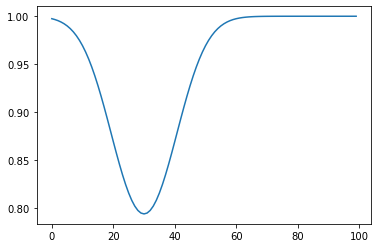

In [248]:
plt.plot(test1[1,:])

In [249]:
ori = training_generator[0][0][:2]
ori.shape

(2, 100, 282, 1)

In [250]:
res = ori * test1[:,:,np.newaxis, np.newaxis]

0:th batch sample / 16
[  0  16  42  68  85 100]
[0.79903634 1.         1.         1.         1.         0.69480446]


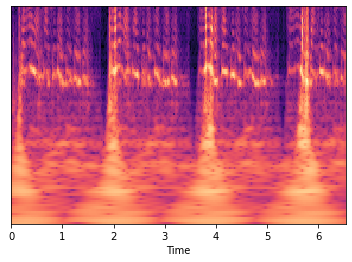

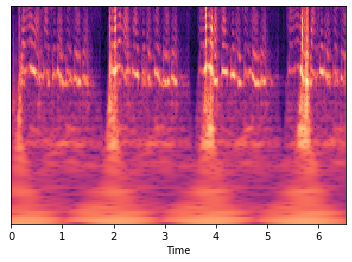

In [251]:
i = 0
print("{}:th batch sample / 16".format(i))
print(band_bndry_freqs)
print( 10 ** (band_factors[i]/20))
fig, ax = plt.subplots()
img = librosa.display.specshow(ori[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(res[i][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)


In [130]:
params = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': True,
          'beta_param': 0.7,
          'data_dir': add2022,
          'filteraug': [ [3, 6], 6, "step", [-6,6]]
#          'specmix': [[2,10], [2,15]],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': False,
          'data_dir': add2022,
          #'device': device
}

In [131]:
training_generator = DataGenerator(dl.train, dl.labels, **params)
validation_generator = DataGenerator(dl.dev, dl.labels, **params_no_shuffle)
evaluation_generator = DataGenerator(dl.eval, dl.labels, **params_no_shuffle)

cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)


In [132]:
training_generator[0][0].shape

(16, 100, 282, 1)

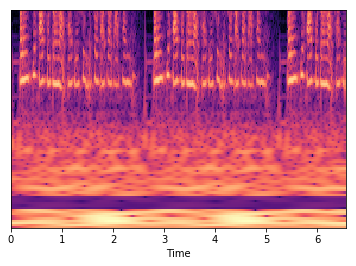

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[0][0][0][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)

In [23]:
params = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': True,
          'beta_param': 0.7,
          'data_dir': add2022,
          'filteraug': [ [3, 6], 6, "step", [-6,6]]
#          'specmix': [[2,10], [2,15]],
          #'highpass': [78,79,80,81,82,83,84,85],
#          'ranfilter2' : [3, [18,19,20,21,22,23]]
#           'dropblock' : [30, 100]
          #'device' : device
}

params_no_shuffle = {'sr': sr,
          'batch_size': batch_size,
          'feature': feature,
          'n_classes': 2,
          'sec': sec,
          'filter_scale': filter_scale,
          'fmin' : fmin,
          'n_bins': n_bins,
          'tofile': tmp_string,
          'shuffle': False,
          'data_dir': add2022,
          #'device': device
}

In [24]:
training_generator = DataGenerator(dl.train, dl.labels, **params)
validation_generator = DataGenerator(dl.dev, dl.labels, **params_no_shuffle)
evaluation_generator = DataGenerator(dl.eval, dl.labels, **params_no_shuffle)

cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)
cqt
Input_shape:(100,282,1)


In [25]:
training_generator[0][0].shape

(16, 100, 282, 1)

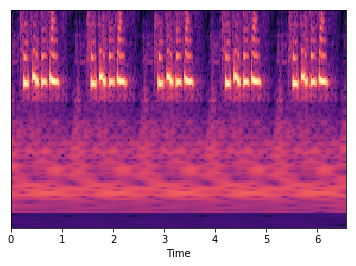

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots()
img = librosa.display.specshow(training_generator[0][0][0][:,:,0], x_axis='time',# y_axis='log',
                               ax=ax)

In [21]:
training_generator[0][0].shape

(16, 100, 282, 1)

In [22]:
#validation_generator[0][0].shape

In [23]:
input_shape = training_generator.get_input_shape()

In [24]:
input_shape

(100, 282, 1)

### Baseline

In [25]:
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.layers import Conv2D, maximum, add, SeparableConv2D
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import roc_curve

In [26]:
in1 = Input(shape = input_shape)
c1 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(in1)
c2 = Conv2D(filters = 32, kernel_size =5, strides=(1, 1), padding='same', activation=None)(in1)
x = maximum([c1, c2])
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

c1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)

c1 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 48, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = BatchNormalization(axis=3, scale=False)(x)

c1 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 48, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)

c1 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 64, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

c1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)

c1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

c1 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 64, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)

c1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

c1 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 32, kernel_size =1, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)

c1 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
c2 = Conv2D(filters = 32, kernel_size =3, strides=(1, 1), padding='same', activation=None)(x)
x = maximum([c1, c2])
x = BatchNormalization(axis=3, scale=False)(x)
x = Dropout(.5)(x)
#x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)
x = GlobalAveragePooling2D(data_format='channels_last')(x)
#x = Flatten()(x)
#f1 = Dense(80, activation = None)(x)
#f2 = Dense(80, activation = None)(x)
#x = keras.layers.maximum([f1, f2])
x = BatchNormalization()(x)
x = Dropout(.5)(x)
x = Dense(2, activation = 'softmax')(x)
model = Model(inputs = in1, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 282, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 282, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 282, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
maximum (Maximum)               (None, 100, 282, 32) 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

### Train LCNN model

In [27]:
def sigmoidal_decay(e, start=0, end=100, lr_start=1e-3, lr_end=1e-5):
    if e < start:
        return lr_start    
    if e > end:
        return lr_end    
    middle = (start + end) / 2
    s = lambda x: 1 / (1 + np.exp(-x))    
    return s(13 * (-e + middle) / np.abs(end - start)) * np.abs(lr_start - lr_end) + lr_end

In [28]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

EPOCHS = epoch
lr = LearningRateScheduler(lambda e: sigmoidal_decay(e, end=EPOCHS))
#filepath="saved_models/BC_ResMax_cqt_mixup_hp_"+str(params['sec'])+"_"+str(params['filter_scale'])+"_"+str(params['fmin'])+"_"+str(params['n_bins'])+"-2-{epoch:02d}.hdf5"
#mc = ModelCheckpoint(filepath, monitor='val_auc', verbose=1)
class_weight = {0: human_weight, 1: 1.} ## human: 0, 1: speaker

history = model.fit_generator(generator=training_generator, #validation_data=validation_generator,
                    epochs=EPOCHS, class_weight=class_weight, callbacks=[lr], verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1692/1692 [==============================] - 1456s 860ms/step - loss: 0.6051 - auc: 0.9099 - lr: 9.9851e-04
Epoch 2/50
1692/1692 [==============================] - 563s 333ms/step - loss: 0.4306 - auc: 0.9548 - lr: 9.9807e-04
Epoch 3/50
1692/1692 [==============================] - 563s 332ms/step - loss: 0.4045 - auc: 0.9604 - lr: 9.9750e-04
Epoch 4/50
1692/1692 [==============================] - 560s 331ms/step - loss: 0.3885 - auc: 0.9614 - lr: 9.9676e-04
Epoch 5/50
1692/1692 [==============================] - 561s 331ms/step - loss: 0.3829 - auc: 0.9644 - lr: 9.9581e-04
Epoch 6/50
1692/1692 [==============================] - 561s 331ms/step - loss: 0.3684 - auc: 0.9656 - lr: 9.9457e-04
Epoch 7/50
1692/1692 [==============================] - 560s 331ms/step - loss: 0.3566 - auc: 0.9677 - lr: 9.9297e-04
Epoch 8/50
1692/

KeyboardInterrupt: 

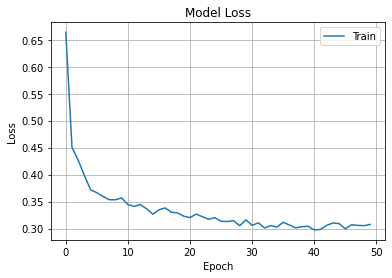

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'#, 'Validation'
           ], loc='upper right')
plt.show()

## Evaluation EER

In [27]:
eer_dev = evalEER(validation_generator, model)
eer_dev

/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


EER: 0.0002936163207782745


0.0002936163207782745

In [28]:
eer_eval = evalEER(evaluation_generator, model)
eer_eval

/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


EER: 0.15733855185909978


0.15733855185909978

In [33]:
endtxt1 = str(eer_eval)[:6] + '.hdf5'
savefnm = gen_fname(model_name = "LCNN", params = params , dropout_rate = str(dropout_rate), human_weight = str(human_weight), endtxt = endtxt1 )
savefnm = 'saved_models/' + savefnm
savefnm
model.save(savefnm)

In [32]:

sc1 = evalScore(evaluation_generator, model)
endtxt1 = str(eer_eval)[:6] + '.npy'
fnm = gen_fname(model_name = "LCNN", params = params , dropout_rate = str(dropout_rate), human_weight = str(human_weight), endtxt = endtxt1)
fnm = 'saved_results/' + fnm
np.save(fnm, sc1)

In [35]:
import pickle

params_save = params
params_save['model'] = "LCNN"
params_save['human_weight'] = str(human_weight)
params_save['dropout_rate'] = str(dropout_rate)
params_save['eer'] = str(eer_eval)[:6]
params_save['saved_model'] = savefnm
params_save['saved_result'] = fnm
tnow = datetime.datetime.now()
fnm = 'res/rec'+str(tnow) + '.pickle'
with open(fnm, 'wb') as f:
    pickle.dump(params_save, f, pickle.HIGHEST_PROTOCOL)